In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import time
import xgboost as xgb
import random as python_random
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from keras import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.optimizers import Adam
from keras.initializers import Constant as constant_init
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from keras.callbacks import EarlyStopping

plt.style.use('ggplot')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:.2f}'.format

Using TensorFlow backend.


## Task definition

For the short-term consumption/load forecasting case, we will try forecasting the energy consumption 2.5 days/60 hours ahead.

## Set seeds

In [2]:
random_seed = 100
python_random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Contents
- #### [Baseline models](#baseline_models)
    - ##### [Consumption one week ago](#baseline_models_1)
    - ##### [Mean consumtion last 24 hours](#baseline_models_2)
- #### [Linear regression](#linear_regression)
- #### [Random forest](#random_forest)
- #### [Gradient boosting - XGBoost](#xgboost)
    - ##### [XGBoost without temperature as a feature](#xgboost)
    - ##### [XGBoost with measured and forecasted temperature](#xgboost_w_measured_and_forecasted_temp)
    - ##### [XGBoost with measured temperature only](#xgboost_w_measured_temp)
- #### [Recurrent neural network](#rnn)

## Utils

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    # Note: Will throw error if there are any zeros in the target variable
    
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

In [4]:
def add_results(model_name, df_results, y_true, y_pred):
    
    # Ignore NaNs
    y_true_nonans = y_true[~y_pred.isna()]
    y_pred_nonans = y_pred[~y_pred.isna()]
    
    r2 = str(round(r2_score(y_true_nonans, y_pred_nonans), 3))
    rmse = str(round(np.sqrt(mean_squared_error(y_true_nonans, y_pred_nonans)), 2))
    mae = str(round(mean_absolute_error(y_true_nonans, y_pred_nonans), 1))
    mape = str(round(mean_absolute_percentage_error(y_true_nonans, y_pred_nonans), 2)) + '%'
    
    df_results.loc[0 if pd.isnull(df_results.index.max()) else df_results.index.max() + 1] = [model_name, r2, rmse, mae, mape]

In [5]:
def plot_predictions(y_test, y_pred, model_name, df_test, start: pd.Timestamp, end: pd.Timestamp, forecast_length: int=60):
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    start_idx = df_test[df_test['Datetime UTC+1'] == start].index[0]
    end_idx = df_test[df_test['Datetime UTC+1'] == end].index[0]
    
    ax.plot(df_test.loc[start_idx:end_idx, 'Datetime UTC+1'], y_test[start_idx:end_idx + 1], 'r', lw=2, label='Measured consumption')
    ax.plot(df_test.loc[start_idx:end_idx, 'Datetime UTC+1'], y_pred[start_idx:end_idx + 1], 'k--', lw=1.5, label='Forecasted consumption')
    
    forecast_interval_starts = [idx for idx in range(0, len(y_test) - forecast_length, forecast_length) \
                                 if idx in range(start_idx, end_idx + 1)]
    for i, idx in enumerate(forecast_interval_starts):
        if i == 0:
            label = 'Forecast interval start'
        else:
            label = None
        ax.axvline(df_test.loc[idx, 'Datetime UTC+1'], color='k', ls=':', lw=1.5, label=label)
    
    ax.set_title(model_name + ' forecast examples')
    ax.set_ylabel('MWh', rotation=0, fontsize=12)
    ax.yaxis.set_label_coords(-0.07, 0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    
    return fig

In [6]:
def stepwise_forecast(model, x_test, 
                      forecast_length: int=60,
                      pipeline: bool=True, 
                      lag_col_idx: int=0,
                      scaler=None) -> pd.Series:
    
    if pipeline:
        lag_col_idx = x_test.columns.get_loc('consumption_lag_1h')
    else:
        assert lag_col_idx != 0, 'When not using a pipeline, specify the column index for lag features!'
    
    y_pred = [np.nan] * len(x_test)
    x_test_stepwise = x_test.copy().values
    
    for i in range(0, len(x_test) - forecast_length, forecast_length):
        for j in range(i, i + forecast_length):
            try:
                if scaler:
                    y_pred[j] = scaler.transform(model.predict(x_test_stepwise[j].reshape(1, -1)))[0][0]
                else:
                    y_pred[j] = model.predict(x_test_stepwise[j].reshape(1, -1))[0]
                if j != (i + forecast_length - 1):
                    x_test_stepwise[j + 1, lag_col_idx] = y_pred[j]
            except Exception as e:
                print(j)
                print(type(e).__name__ + ' occurred:', e)
                
    return pd.Series(y_pred)

In [7]:
def visualize_training_nn(history,
                          train_metric='mean_absolute_error', 
                          val_metric='val_mean_absolute_error'):
    
    loss = history.history[train_metric]
    val_loss = history.history[val_metric]
    epochs = range(len(loss))
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(epochs, loss, "k", label='Training: ' + train_metric)
    ax.plot(epochs, val_loss, "r", label='Validation: ' + val_metric)
    ax.set_xlabel("Epochs", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    
    return fig

In [8]:
def plot_test_results(y_true, y_pred, model_name):
    
    # Ignore NaNs
    y_true_nonans = y_true[~y_pred.isna()]
    y_pred_nonans = y_pred[~y_pred.isna()]
    
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle(model_name, fontsize=13, weight='bold')
    
    diffs = (y_true_nonans - y_pred_nonans)
    ax1 = plt.subplot(1, 2, 1)
    ax1.hist(diffs, color='k', bins=50)
    ax1.set_aspect('auto', adjustable='box')
    ax1.set_title('Distribution of errors', fontsize=12)
    ax1.set_xlabel('MWh')
    ax1.tick_params(axis='both', which='major', labelsize=12)
    
    all_vals = pd.concat((y_true_nonans, y_pred_nonans), axis=0, ignore_index=True)
    min_val = all_vals.min()
    max_val = all_vals.max()
    ax2 = plt.subplot(1, 2, 2, aspect=1)
    ax2.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.5)
    ax2.set_title('Predicted values against measured values', fontsize=12)
    ax2.scatter(y_true_nonans, y_pred_nonans, c='r', alpha=1, s=5)
    ax2.set_xlabel('MWh, measured')
    ax2.set_ylabel('MWh,\nfore-\ncasted', rotation=0)
    ax2.yaxis.set_label_coords(-0.2, 0.5)
    ax2.xaxis.set_label_coords(0.5, -0.1)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplots_adjust(wspace=0.25)

    return fig

## Load data

In [9]:
df_train = pd.read_csv('../../data/NordPool/merged_data/train_set.csv', parse_dates=['Datetime UTC+1'])
df_test = pd.read_csv('../../data/NordPool/merged_data/test_set.csv', parse_dates=['Datetime UTC+1'])

In [10]:
x_train = df_train[['Datetime UTC+1', 'NO5', 'temperature', 'temperature_forecast']]
y_train = df_train.NO5

x_test = df_test[['Datetime UTC+1', 'NO5', 'temperature', 'temperature_forecast']]
y_test = df_test.NO5

In [11]:
print('Number of 60 hour periods in test set:', len(y_test)/60)

Number of 60 hour periods in test set: 146.0


### Dataframe for results

In [12]:
# Dataframe for keeping track of results
df_results = pd.DataFrame(columns=['model', 'r2-score', 'rmse', 'mae', 'mape'])

heading_properties, cell_properties = [('font-size', '14px'), ('weight', 'bold')], [('font-size', '14px')]
dfstyle = [dict(selector="th", props=heading_properties), dict(selector="td", props=cell_properties)]

## Baseline models <a name="baseline_models"></a>

First, let's look at some baseline models that more advanced models can be compared against later.

### Consumption one week ago <a name="baseline_models_1"></a>

In [13]:
def naive_forecast_7d_ago(y_test: pd.Series) -> pd.Series:
    return y_test.shift(periods=7 * 24)

In [14]:
y_pred_naive_7d = naive_forecast_7d_ago(y_test)
add_results('naive_7d_ago', df_results, y_test, y_pred_naive_7d)

In [15]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,rmse,mae,mape
0,naive_7d_ago,0.772,173.29,134.1,7.82%


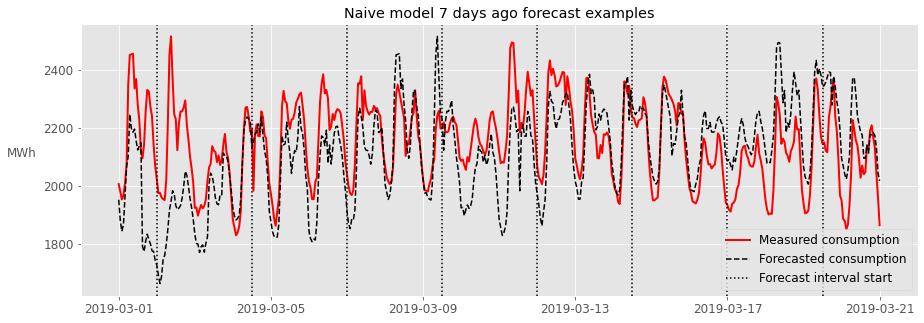

In [16]:
fig = plot_predictions(y_test, y_pred_naive_7d, 'Naive model 7 days ago', df_test, 
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [17]:
fig.savefig('../../plots/NordPool/modelling/naive_7d_ago_forecast_examples_1.png', bbox_inches='tight')

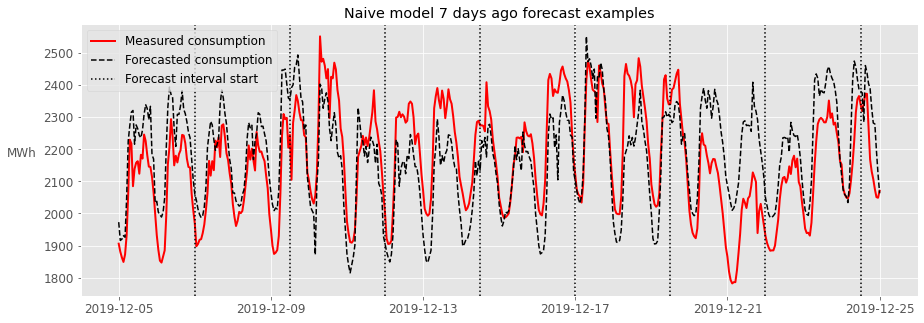

In [18]:
fig = plot_predictions(y_test, y_pred_naive_7d, 'Naive model 7 days ago', df_test, 
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [19]:
fig.savefig('../../plots/NordPool/modelling/naive_7d_ago_forecast_examples_2.png', bbox_inches='tight')

### Mean consumption last 24 hours <a name="baseline_models_2"></a>

In [20]:
def naive_forecast_24h_mean(y_test: pd.Series, n_forecast_hours: int = 60) -> pd.Series:
    
    y_pred = pd.Series([np.nan] * len(y_test))
    
    for i in range(0, len(y_test), n_forecast_hours):
        try:
            y_pred.loc[i:(i + n_forecast_hours)] = y_test.loc[(i - 25):(i - 1)].mean()
        except Exception as e:
            print(type(e).__name__ + ' occurred')
    
    return y_pred

In [21]:
y_pred_naive_24h_mean = naive_forecast_24h_mean(y_test)
add_results('naive_24h_mean', df_results, y_test, y_pred_naive_24h_mean)

In [22]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,rmse,mae,mape
0,naive_7d_ago,0.772,173.29,134.1,7.82%
1,naive_24h_mean,0.793,164.89,132.4,7.56%


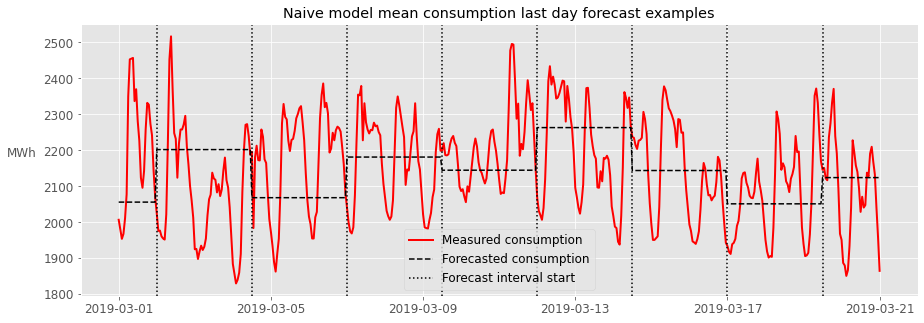

In [23]:
fig = plot_predictions(y_test, y_pred_naive_24h_mean, 'Naive model mean consumption last day', df_test,
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [24]:
fig.savefig('../../plots/NordPool/modelling/naive_24h_mean_forecast_examples_1.png', bbox_inches='tight')

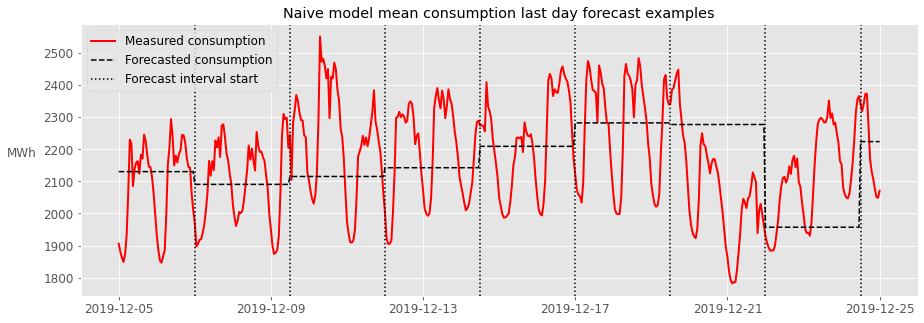

In [25]:
fig = plot_predictions(y_test, y_pred_naive_24h_mean, 'Naive model mean consumption last day', df_test, 
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [26]:
fig.savefig('../../plots/NordPool/modelling/naive_24h_mean_forecast_examples_2.png', bbox_inches='tight')

## Linear regression <a name="linear_regression"></a>

In [27]:
def prep_features(df: pd.DataFrame, drop_temp: bool=True, recurrent_nn: bool=False) -> pd.DataFrame:  
    
    df = df.copy()
    
    # Add datetime features
    df['hour'] = df['Datetime UTC+1'].dt.hour
    df['month'] = df['Datetime UTC+1'].dt.month
    
    df['weekday'] = 0
    df.loc[df['Datetime UTC+1'].dt.weekday.isin([0, 1, 2, 3, 4]), 'weekday'] = 1
    
    df['saturday'], df['sunday'] = 0, 0
    df.loc[df['Datetime UTC+1'].dt.weekday == 5, 'saturday'] = 1
    df.loc[df['Datetime UTC+1'].dt.weekday == 6, 'sunday'] = 1
    
    # Add lag feature, not needed for the recurrent neural network (code for RNN)
    if not recurrent_nn:
        df.loc[:, 'consumption_lag_1h'] = df['NO5'].shift(1)
    
    # Add holiday feature
    nor_holidays = holidays.NO(years=range(2013, 2020))

    holiday_dict = dict()
    for date, holiday_name in nor_holidays.items():
        if holiday_name != 'Søndag': # Remove sundays (søndag)
            holiday_dict[date] = holiday_name

    df['holiday'] = 0
    df.loc[df['Datetime UTC+1'].dt.date.isin(holiday_dict.keys()), 'holiday'] = 1
    
    # Drop columns not needed
    if drop_temp: 
        if not recurrent_nn:
            drop_cols = ['NO5', 'temperature', 'temperature_forecast']
        else:
            drop_cols = ['temperature', 'temperature_forecast']
    else:
        drop_cols =  ['NO5']
    df.drop(drop_cols, axis=1, inplace=True)
    
    return df

In [28]:
x_train_w_feats = prep_features(x_train, drop_temp=True)
x_test_w_feats = prep_features(x_test, drop_temp=True)

x_train_w_feats.drop('Datetime UTC+1', axis=1, inplace=True)
x_test_w_feats.drop('Datetime UTC+1', axis=1, inplace=True)

In [29]:
x_train_w_feats.head()

,hour,month,weekday,saturday,sunday,consumption_lag_1h,holiday
0,1,1,1,0,0,nan,1
1,2,1,1,0,0,1927.00,1
2,3,1,1,0,0,1886.00,1
3,4,1,1,0,0,1894.00,1
4,5,1,1,0,0,1870.00,1


In [30]:
ohe = ColumnTransformer(
    [('ohe', OneHotEncoder(), [0, 1])], # One-hot encode hour and month
    remainder='passthrough'
)

linear_regressor = LinearRegression(fit_intercept=True, normalize=False)

estimator = Pipeline(
    [('ohe', ohe),
     ('imputer', SimpleImputer(strategy='median')),
     ('regressor', linear_regressor)]
)

In [31]:
estimator.fit(X=x_train_w_feats.values, y=y_train)

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  [0, 1])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('regressor', LinearRegression())])

In [32]:
y_pred_lr_stepwise = stepwise_forecast(model=estimator, x_test=x_test_w_feats)
add_results('linear_regression', df_results, y_test, y_pred_lr_stepwise)

In [33]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,rmse,mae,mape
0,naive_7d_ago,0.772,173.29,134.1,7.82%
1,naive_24h_mean,0.793,164.89,132.4,7.56%
2,linear_regression,0.86,135.99,102.5,6.09%


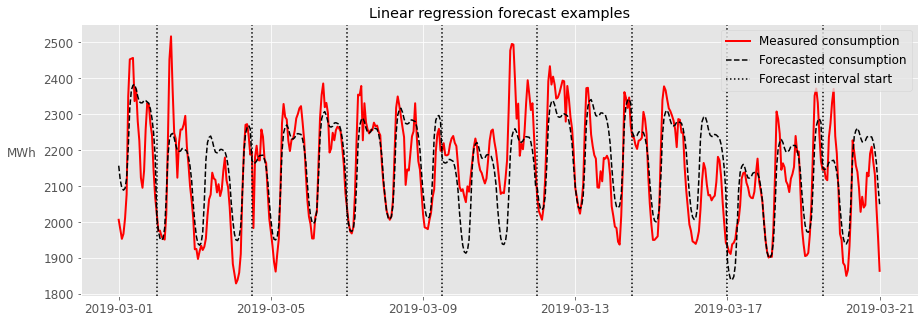

In [34]:
fig = plot_predictions(y_test, y_pred_lr_stepwise, 'Linear regression', df_test, 
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [35]:
fig.savefig('../../plots/NordPool/modelling/linear_regression_forecast_examples_1.png', bbox_inches='tight')

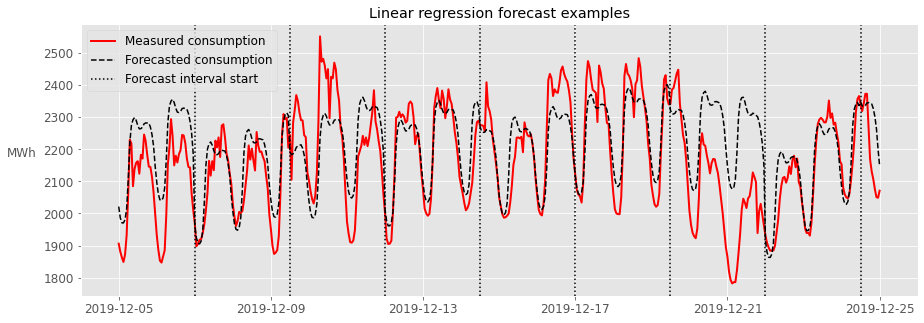

In [36]:
fig = plot_predictions(y_test, y_pred_lr_stepwise, 'Linear regression', df_test,
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [37]:
fig.savefig('../../plots/NordPool/modelling/linear_regression_forecast_examples_2.png', bbox_inches='tight')

## Random forest <a name="random_forest"></a>

In [38]:
rf_regressor = RandomForestRegressor(n_jobs=-1)

estimator = Pipeline(
    [('ohe', ohe),
     ('imputer', SimpleImputer(strategy='median')),
     ('regressor', rf_regressor)]
)

In [39]:
# hyperparameter_space = {
#     'regressor__n_estimators': [100, 200, 300, 400, 500],
#     'regressor__max_depth': [None, 3, 5, 7, 9],
#     'regressor__min_samples_split': [2, 5, 10],
#     'regressor__min_samples_leaf': [1, 2, 5],
#     'regressor__bootstrap': [True, False],
#     'regressor__max_samples': [None, 0.2, 0.5, 0.8]
# }

# cv = TimeSeriesSplit(n_splits=5)

# rand_search_cv = RandomizedSearchCV(estimator=estimator, 
#                                     param_distributions=hyperparameter_space,
#                                     n_iter=40,
#                                     cv=cv,
#                                     scoring='neg_mean_absolute_error',
#                                     n_jobs=-1,
#                                     refit=False,
#                                     return_train_score=True,
#                                     verbose=20)

# rand_search_cv.fit(x_train_w_feats, y_train)

In [40]:
# rand_search_cv.best_params_

In [41]:
best_params = {'n_estimators': 400,
               'min_samples_split': 5,
               'min_samples_leaf': 2,
               'max_samples': 0.2,
               'max_depth': None,
               'bootstrap': True}

rf_regressor = RandomForestRegressor(**best_params, n_jobs=-1)

preprocessor = Pipeline(
    [('ohe', ohe),
     ('imputer', SimpleImputer(strategy='median'))]
)

In [42]:
x_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(x_train_w_feats).toarray())
x_test_preprocessed = pd.DataFrame(preprocessor.transform(x_test_w_feats).toarray())

In [43]:
rf_regressor.fit(X=x_train_preprocessed.values, y=y_train)

RandomForestRegressor(max_samples=0.2, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=400, n_jobs=-1)

In [44]:
y_pred_rf = stepwise_forecast(rf_regressor, x_test_preprocessed, pipeline=False, lag_col_idx=39)

In [45]:
add_results('random_forest', df_results, y_test, y_pred_rf)

In [46]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,rmse,mae,mape
0,naive_7d_ago,0.772,173.29,134.1,7.82%
1,naive_24h_mean,0.793,164.89,132.4,7.56%
2,linear_regression,0.86,135.99,102.5,6.09%
3,random_forest,0.886,122.38,90.1,5.44%


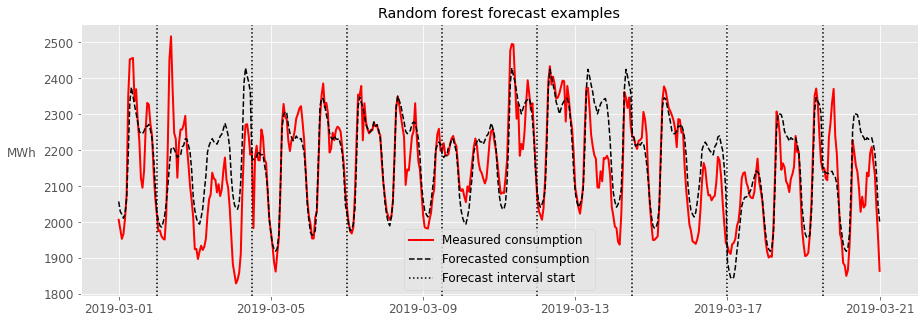

In [47]:
fig = plot_predictions(y_test, y_pred_rf, 'Random forest', df_test, 
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [48]:
fig.savefig('../../plots/NordPool/modelling/random_forest_forecast_examples_1.png', bbox_inches='tight')

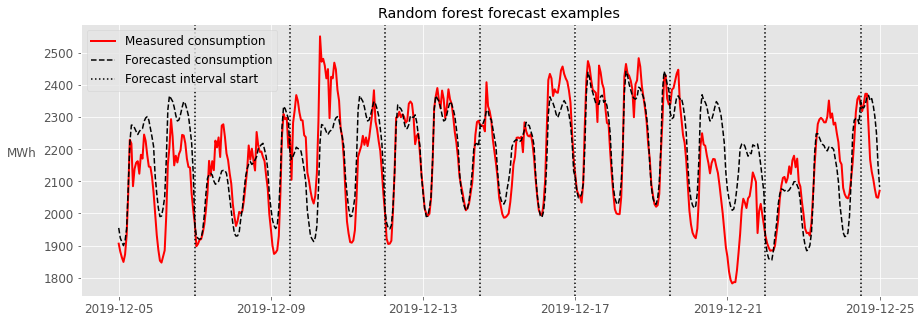

In [49]:
fig = plot_predictions(y_test, y_pred_rf, 'Random forest', df_test,
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [50]:
fig.savefig('../../plots/NordPool/modelling/random_forest_forecast_examples_2.png', bbox_inches='tight')

## Gradient boosting - XGBoost <a name="xgboost"></a>

### XGBoost without temperature feature

In [51]:
x_train_w_temp = prep_features(x_train, drop_temp=True)
x_test_w_temp = prep_features(x_test, drop_temp=True)

x_train_w_temp.drop(['Datetime UTC+1'], axis=1, inplace=True)
x_test_w_temp.drop(['Datetime UTC+1'], axis=1, inplace=True)

In [52]:
# xgb_regressor = xgb.XGBRegressor(n_jobs=-1)

# estimator = Pipeline(
#     [('ohe', ohe),
#      ('imputer', SimpleImputer(strategy='median')),
#      ('regressor', xgb_regressor)]
# )

# hyperparameter_space = {
#     'regressor__n_estimators': [100, 300, 500, 700, 900],
#     'regressor__max_depth': [None, 3, 5, 7, 9],
#     'regressor__learning_rate': [0.05, 0.1, 0.15],
#     'regressor__colsample_bytree': [0.2, 0.5, 0.8, 1],
#     'regressor__subsample': [0.2, 0.5, 0.8, 1],
#     'regressor__gamma': [0, 1, 2]
# }

# cv = TimeSeriesSplit(n_splits=5)

# rand_search_cv = RandomizedSearchCV(estimator=estimator, 
#                                     param_distributions=hyperparameter_space,
#                                     n_iter=40,
#                                     cv=cv,
#                                     scoring='neg_mean_absolute_error',
#                                     n_jobs=-1,
#                                     refit=False,
#                                     return_train_score=True,
#                                     verbose=20)

# rand_search_cv.fit(x_train_w_feats, y_train)

In [53]:
# rand_search_cv.best_params_

In [54]:
best_params = {'subsample': 0.5,
               'n_estimators': 300,
               'max_depth': 5,
               'learning_rate': 0.05,
               'gamma': 0,
               'colsample_bytree': 1}

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', **best_params, n_jobs=-1)

estimator = Pipeline(
    [('ohe', ohe),
     ('imputer', SimpleImputer(strategy='median')),
     ('regressor', xgb_regressor)]
)

In [55]:
estimator.fit(X=x_train_w_feats, y=y_train)

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  [0, 1])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight

In [56]:
y_pred_xgb = stepwise_forecast(estimator, x_test_w_feats, pipeline=True)

In [57]:
add_results('xgboost', df_results, y_test, y_pred_xgb)

In [58]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,rmse,mae,mape
0,naive_7d_ago,0.772,173.29,134.1,7.82%
1,naive_24h_mean,0.793,164.89,132.4,7.56%
2,linear_regression,0.86,135.99,102.5,6.09%
3,random_forest,0.886,122.38,90.1,5.44%
4,xgboost,0.905,112.01,82.7,4.93%


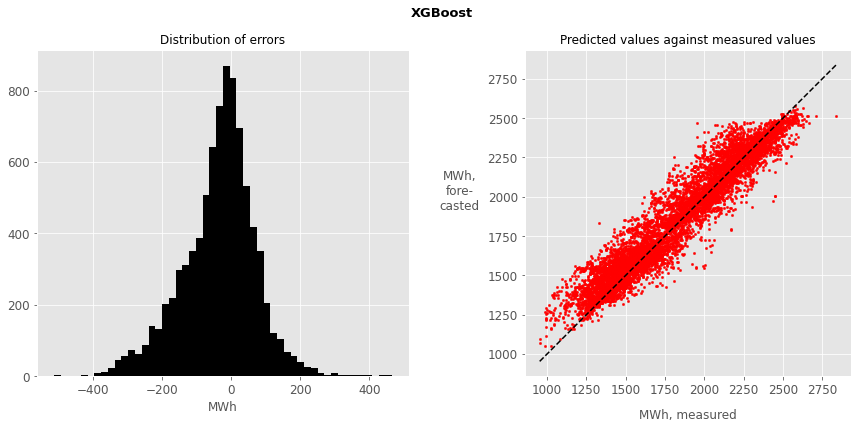

In [59]:
fig = plot_test_results(y_test, y_pred_xgb, 'XGBoost')

In [60]:
fig.savefig('../../plots/NordPool/modelling/errors_xgboost.png', bbox_inches='tight')

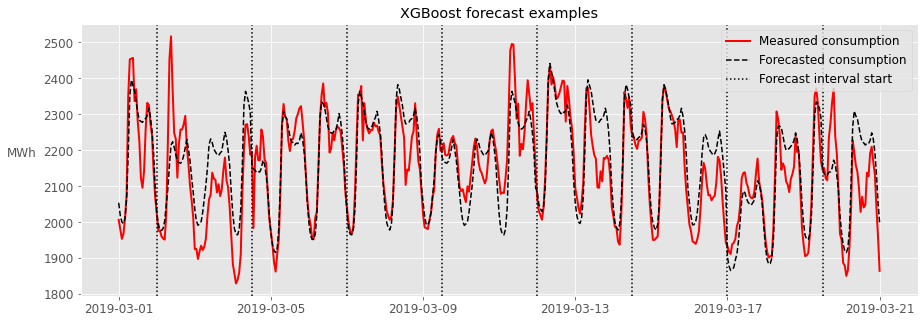

In [61]:
fig = plot_predictions(y_test, y_pred_xgb, 'XGBoost', df_test, 
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [62]:
fig.savefig('../../plots/NordPool/modelling/xgboost_forecast_examples_1.png', bbox_inches='tight')

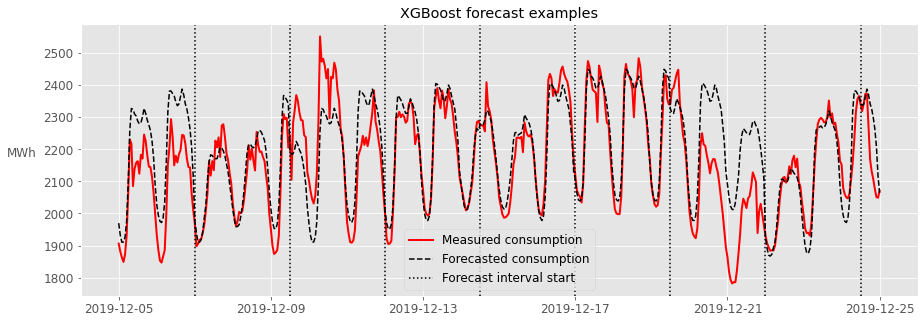

In [63]:
fig = plot_predictions(y_test, y_pred_xgb, 'XGBoost', df_test,
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [64]:
fig.savefig('../../plots/NordPool/modelling/xgboost_forecast_examples_2.png', bbox_inches='tight')

In the last plots, the model seems to be fairly accurate for most of the chosen days. But, on some days like the 10th, 20th and 21st of December, there is a rather large difference between predictions and the measurements. Since we have temperature data available, we can plot the measured and forecasted temperatures for these dates:

![](../../plots/NordPool/eda_and_prep/comparison_measured_and_forecasted_temp_bergen_2.png)

There is a drop in temperature around the 10th and a clear rise in temperature between the 19th and 22nd of December. Let's see how much better our models will perform using temperature data in addition to the other features.

### XGBoost with temperature feature, using both measured and forecasted temperature

If the model developed here was to be used in production, it would have to rely on temperature forecast data when doing forecasting/inferencing. Therefore, we will use forecast data in the test set (2019) to simulate this situation. For training, one could have used weather forecast data as well, maybe giving the model some idea of inaccuracies in the forecasts. Since we, as part of the EDA, already downloaded and inspected the measured temperatures for Florida, Bergen, we will for simplicity use this data in the training set here.

In [65]:
x_train_w_temp = prep_features(x_train, drop_temp=False)
x_test_w_temp = prep_features(x_test, drop_temp=False)

x_train_w_temp.drop(['Datetime UTC+1', 'temperature_forecast'], axis=1, inplace=True)
x_test_w_temp.drop(['Datetime UTC+1', 'temperature'], axis=1, inplace=True)
x_test_w_temp.rename({'temperature_forecast': 'temperature'}, axis=1, inplace=True)

In [66]:
# Reorder columns
x_train_w_temp = x_train_w_temp[['hour', 'month', 'weekday', 'saturday', 'sunday', 'consumption_lag_1h', 'holiday', 'temperature']]
x_test_w_temp = x_test_w_temp[['hour', 'month', 'weekday', 'saturday', 'sunday', 'consumption_lag_1h', 'holiday', 'temperature']]

In [67]:
x_train_w_temp.head(3)

,hour,month,weekday,saturday,sunday,consumption_lag_1h,holiday,temperature
0,1,1,1,0,0,nan,1,6.00
1,2,1,1,0,0,1927.00,1,6.00
2,3,1,1,0,0,1886.00,1,5.50


In [68]:
x_test_w_temp.head(3)

,hour,month,weekday,saturday,sunday,consumption_lag_1h,holiday,temperature
0,0,1,1,0,0,nan,1,nan
1,1,1,1,0,0,1727.00,1,5.61
2,2,1,1,0,0,1681.00,1,5.33


In [69]:
# xgb_regressor = xgb.XGBRegressor(n_jobs=-1)

# estimator = Pipeline(
#     [('ohe', ohe),
#      ('imputer', SimpleImputer(strategy='median')),
#      ('regressor', xgb_regressor)]
# )

# hyperparameter_space = {
#     'regressor__n_estimators': [100, 300, 500, 700, 900],
#     'regressor__max_depth': [None, 3, 5, 7, 9],
#     'regressor__learning_rate': [0.05, 0.1, 0.15],
#     'regressor__colsample_bytree': [0.2, 0.5, 0.8, 1],
#     'regressor__subsample': [0.2, 0.5, 0.8, 1],
#     'regressor__gamma': [0, 1, 2]
# }

# cv = TimeSeriesSplit(n_splits=5)

# rand_search_cv = RandomizedSearchCV(estimator=estimator, 
#                                     param_distributions=hyperparameter_space,
#                                     n_iter=40,
#                                     cv=cv,
#                                     scoring='neg_mean_absolute_error',
#                                     n_jobs=-1,
#                                     refit=False,
#                                     return_train_score=True,
#                                     verbose=20)

# rand_search_cv.fit(x_train_w_temp, y_train)

In [70]:
# rand_search_cv.best_params_

In [71]:
best_params = {'subsample': 1,
               'n_estimators': 500,
               'max_depth': 3,
               'learning_rate': 0.05,
               'gamma': 0,
               'colsample_bytree': 1}

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', **best_params, n_jobs=-1)

estimator = Pipeline(
    [('ohe', ohe),
     ('imputer', SimpleImputer(strategy='median')),
     ('regressor', xgb_regressor)]
)

In [72]:
estimator.fit(X=x_train_w_temp, y=y_train)

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  [0, 1])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight

In [73]:
y_pred_xgb = stepwise_forecast(estimator, x_test_w_temp, pipeline=True)

In [74]:
add_results('xgboost', df_results, y_test, y_pred_xgb)

In [75]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,rmse,mae,mape
0,naive_7d_ago,0.772,173.29,134.1,7.82%
1,naive_24h_mean,0.793,164.89,132.4,7.56%
2,linear_regression,0.86,135.99,102.5,6.09%
3,random_forest,0.886,122.38,90.1,5.44%
4,xgboost,0.905,112.01,82.7,4.93%
5,xgboost,0.878,126.88,96.7,5.77%


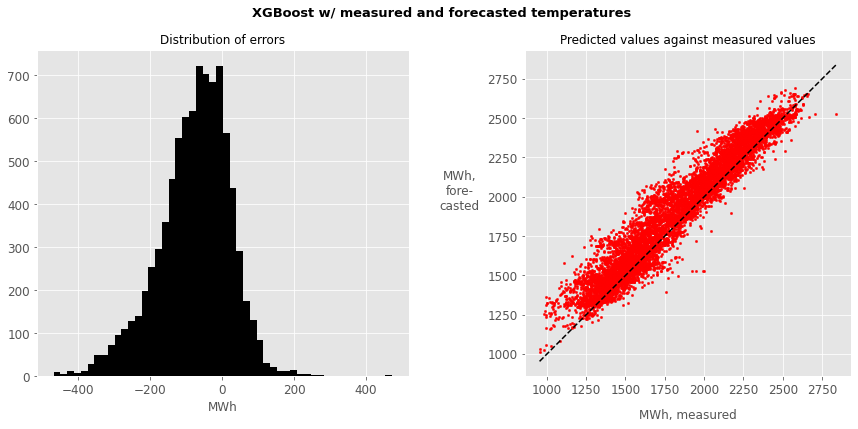

In [76]:
fig = plot_test_results(y_test, y_pred_xgb, 'XGBoost w/ measured and forecasted temperatures')

In [77]:
fig.savefig('../../plots/NordPool/modelling/errors_xgboost_w_measured_forecasted_temp.png', bbox_inches='tight')

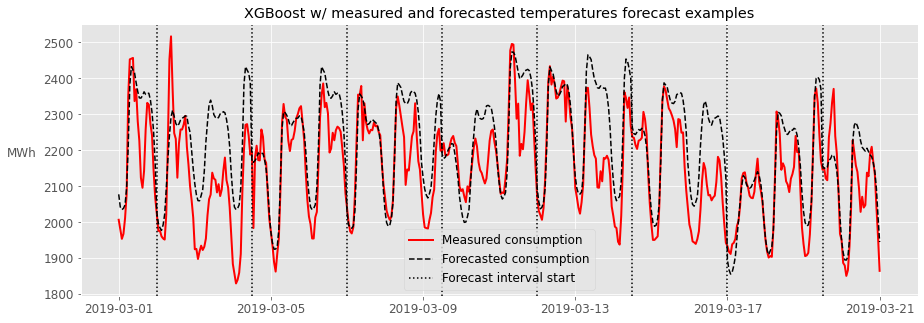

In [78]:
fig = plot_predictions(y_test, y_pred_xgb, 'XGBoost w/ measured and forecasted temperatures', df_test, 
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [79]:
fig.savefig('../../plots/NordPool/modelling/xgboost_forecast_w_temp_forecast_examples_1.png', bbox_inches='tight')

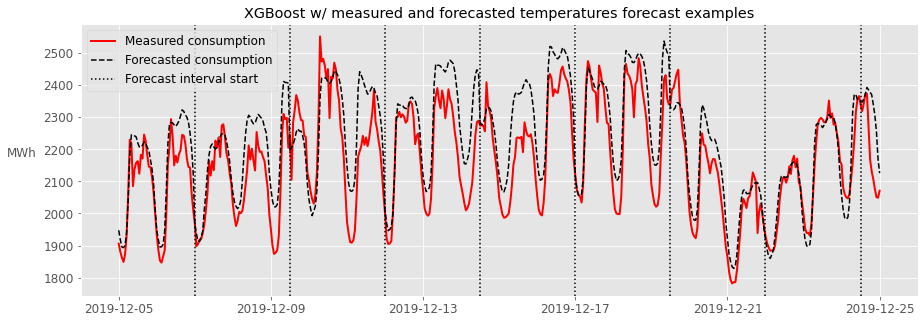

In [80]:
fig = plot_predictions(y_test, y_pred_xgb, 'XGBoost w/ measured and forecasted temperatures', df_test,
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [81]:
fig.savefig('../../plots/NordPool/modelling/xgboost_forecast_w_temp_forecast_examples_2.png', bbox_inches='tight')

### XGBoost with measured temperature feature

If the model developed here was to be used in production, it would have to rely on temperature forecast data when doing forecasting/inferencing. Therefore, we will use forecast data in the test set (2019) to simulate this situation. For training, one could have used weather forecast data as well, maybe giving the model some idea of inaccuracies in the forecasts. Since we, as part of the EDA, already downloaded and inspected the measured temperatures for Florida, Bergen, we will for simplicity use this data in the training set here.

In [82]:
x_train_w_temp = prep_features(x_train, drop_temp=False)
x_test_w_temp = prep_features(x_test, drop_temp=False)

x_train_w_temp.drop(['Datetime UTC+1', 'temperature_forecast'], axis=1, inplace=True)
x_test_w_temp.drop(['Datetime UTC+1', 'temperature_forecast'], axis=1, inplace=True)

In [83]:
# Reorder columns
x_train_w_temp = x_train_w_temp[['hour', 'month', 'weekday', 'saturday', 'sunday', 'consumption_lag_1h', 'holiday', 'temperature']]
x_test_w_temp = x_test_w_temp[['hour', 'month', 'weekday', 'saturday', 'sunday', 'consumption_lag_1h', 'holiday', 'temperature']]

In [84]:
x_train_w_temp.head(3)

,hour,month,weekday,saturday,sunday,consumption_lag_1h,holiday,temperature
0,1,1,1,0,0,nan,1,6.00
1,2,1,1,0,0,1927.00,1,6.00
2,3,1,1,0,0,1886.00,1,5.50


In [85]:
x_test_w_temp.head(3)

,hour,month,weekday,saturday,sunday,consumption_lag_1h,holiday,temperature
0,0,1,1,0,0,nan,1,5.00
1,1,1,1,0,0,1727.00,1,6.60
2,2,1,1,0,0,1681.00,1,6.00


In [86]:
best_params = {'subsample': 1,
               'n_estimators': 500,
               'max_depth': 3,
               'learning_rate': 0.05,
               'gamma': 0,
               'colsample_bytree': 1}

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', **best_params, n_jobs=-1)

estimator = Pipeline(
    [('ohe', ohe),
     ('imputer', SimpleImputer(strategy='median')),
     ('regressor', xgb_regressor)]
)

In [87]:
estimator.fit(X=x_train_w_temp, y=y_train)

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  [0, 1])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight

In [88]:
y_pred_xgb = stepwise_forecast(estimator, x_test_w_temp, pipeline=True)

In [89]:
add_results('xgboost', df_results, y_test, y_pred_xgb)

In [90]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,rmse,mae,mape
0,naive_7d_ago,0.772,173.29,134.1,7.82%
1,naive_24h_mean,0.793,164.89,132.4,7.56%
2,linear_regression,0.86,135.99,102.5,6.09%
3,random_forest,0.886,122.38,90.1,5.44%
4,xgboost,0.905,112.01,82.7,4.93%
5,xgboost,0.878,126.88,96.7,5.77%
6,xgboost,0.908,110.11,83.0,4.98%


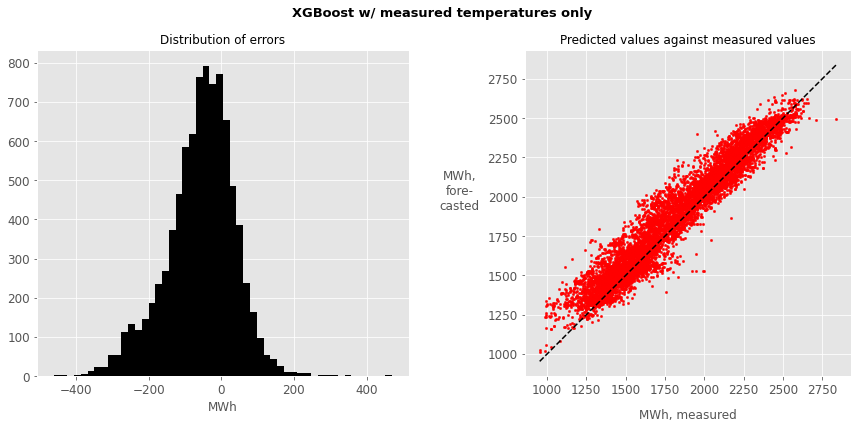

In [91]:
fig = plot_test_results(y_test, y_pred_xgb, 'XGBoost w/ measured temperatures only')

In [92]:
fig.savefig('../../plots/NordPool/modelling/errors_xgboost_w_measured_temp.png', bbox_inches='tight')

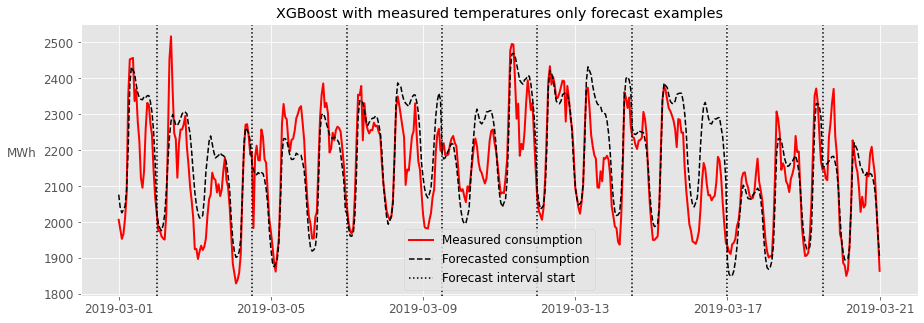

In [93]:
fig = plot_predictions(y_test, y_pred_xgb, 'XGBoost with measured temperatures only', df_test, 
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [94]:
fig.savefig('../../plots/NordPool/modelling/xgboost_forecast_w_temp_measurement_examples_1.png', bbox_inches='tight')

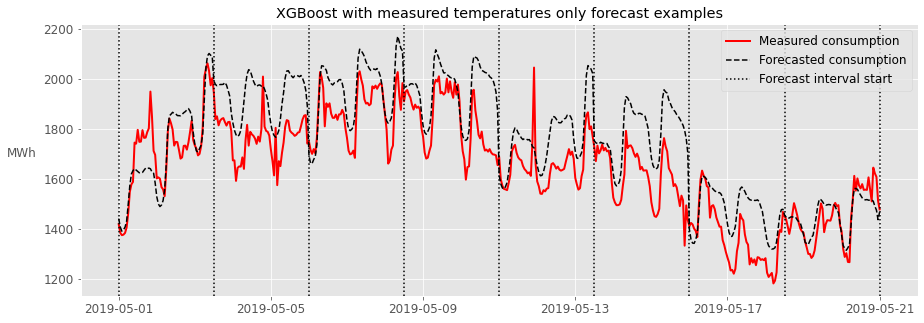

In [95]:
fig = plot_predictions(y_test, y_pred_xgb, 'XGBoost with measured temperatures only', df_test, 
                       start=pd.Timestamp('2019-05-01'), end=pd.Timestamp('2019-05-21'))

In [96]:
fig.savefig('../../plots/NordPool/modelling/xgboost_forecast_w_temp_measurement_examples_2.png', bbox_inches='tight')

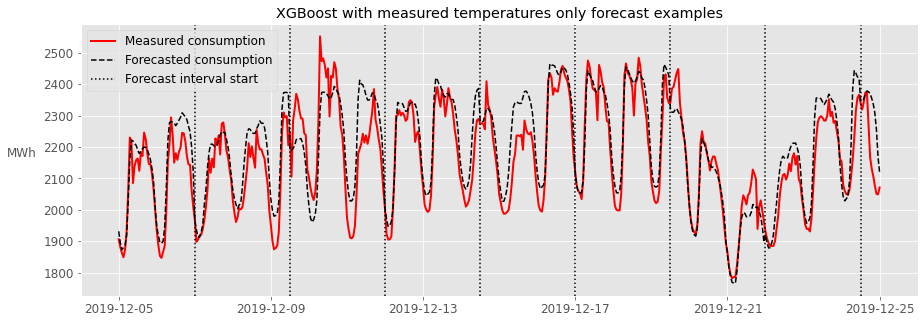

In [97]:
fig = plot_predictions(y_test, y_pred_xgb, 'XGBoost with measured temperatures only', df_test,
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [98]:
fig.savefig('../../plots/NordPool/modelling/xgboost_forecast_w_temp_measurement_examples_3.png', bbox_inches='tight')

## Recurrent neural network <a name="rnn"></a>

In [99]:
x_train_w_feats = prep_features(x_train, drop_temp=True, recurrent_nn=True)
x_test_w_feats = prep_features(x_test, drop_temp=True, recurrent_nn=True)

x_train_w_feats.drop('Datetime UTC+1', axis=1, inplace=True)
x_test_w_feats.drop('Datetime UTC+1', axis=1, inplace=True)

In [100]:
x_train_w_feats.head()

,NO5,hour,month,weekday,saturday,sunday,holiday
0,1927.00,1,1,1,0,0,1
1,1886.00,2,1,1,0,0,1
2,1894.00,3,1,1,0,0,1
3,1870.00,4,1,1,0,0,1
4,1884.00,5,1,1,0,0,1


First, let's standardize the lagged consumption column to a mean of zero and standard deviation of 1:

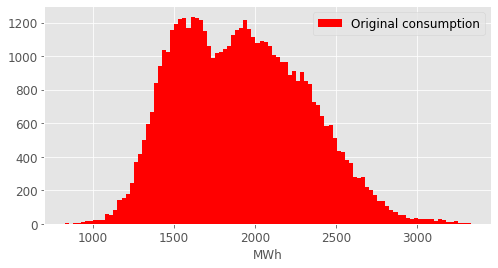

In [101]:
fig, ax = plt.subplots(figsize=(8, 4))
x_train_w_feats['NO5'].plot(kind='hist', color='r', bins=100, ax=ax, label='Original consumption')
ax.set_xlabel('MWh', fontsize=12)
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

In [102]:
scaler = StandardScaler()

x_train_w_feats['NO5'] = scaler.fit_transform(x_train_w_feats['NO5'].values.reshape(-1, 1))
x_test_w_feats['NO5'] = scaler.transform(x_test_w_feats['NO5'].values.reshape(-1, 1))

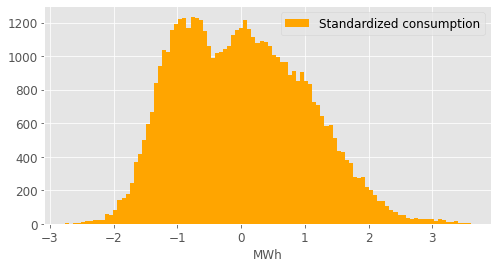

In [103]:
fig, ax = plt.subplots(figsize=(8, 4))
x_train_w_feats['NO5'].plot(kind='hist', color='orange', bins=100, ax=ax, label='Standardized consumption')
ax.set_xlabel('MWh', fontsize=12)
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

Next, let's transform the hour and month features so that they are actually cyclical, meaning that for example the hours 00:00 and 23:00 are close to each other and not on two opposite sides of the feature space. This can for example be done by using sine and cosine functions:

In [104]:
x_train_w_feats['hour_sin'] = x_train_w_feats['hour'].apply(lambda x: np.sin(2 * np.pi * x / 24))
x_train_w_feats['hour_cos'] = x_train_w_feats['hour'].apply(lambda x: np.cos(2 * np.pi * x / 24))
x_test_w_feats['hour_sin'] = x_test_w_feats['hour'].apply(lambda x: np.sin(2 * np.pi * x / 24))
x_test_w_feats['hour_cos'] = x_test_w_feats['hour'].apply(lambda x: np.cos(2 * np.pi * x / 24))

x_train_w_feats['month_sin'] = x_train_w_feats['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))
x_train_w_feats['month_cos'] = x_train_w_feats['month'].apply(lambda x: np.cos(2 * np.pi * x / 12))
x_test_w_feats['month_sin'] = x_test_w_feats['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))
x_test_w_feats['month_cos'] = x_test_w_feats['month'].apply(lambda x: np.cos(2 * np.pi * x / 12))

In [105]:
x_train_w_feats.head()

,NO5,hour,month,weekday,saturday,sunday,holiday,hour_sin,hour_cos,month_sin,month_cos
0,0.03,1,1,1,0,0,1,0.26,0.97,0.50,0.87
1,-0.07,2,1,1,0,0,1,0.50,0.87,0.50,0.87
2,-0.05,3,1,1,0,0,1,0.71,0.71,0.50,0.87
3,-0.11,4,1,1,0,0,1,0.87,0.50,0.50,0.87
4,-0.08,5,1,1,0,0,1,0.97,0.26,0.50,0.87


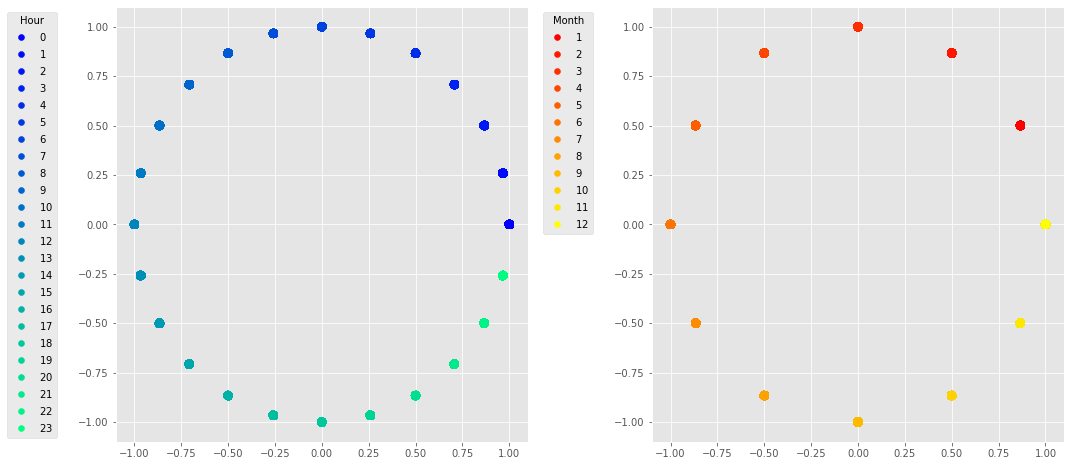

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.3)

scatter1 = ax[0].scatter(x_train_w_feats.hour_cos, x_train_w_feats.hour_sin, s=75, c=x_train_w_feats.hour, cmap='winter')
ax[0].legend(*scatter1.legend_elements(num=24), loc="upper left", title="Hour", bbox_to_anchor=(-0.275, 1))

scatter2 = ax[1].scatter(x_train_w_feats.month_cos, x_train_w_feats.month_sin, s=75, c=x_train_w_feats.month, cmap='autumn')
ax[1].legend(*scatter2.legend_elements(num=12), loc="upper left", title="Month", bbox_to_anchor=(-0.275, 1))
plt.show()

In [107]:
x_train_w_feats.drop(['hour', 'month'], axis=1, inplace=True)
x_test_w_feats.drop(['hour', 'month'], axis=1, inplace=True)

In [108]:
x_train_w_feats['NO5'].fillna(value=x_train_w_feats['NO5'].median(), inplace=True)
x_test_w_feats['NO5'].fillna(value=x_test_w_feats['NO5'].median(), inplace=True)

Next, we need to split the data into sequences to match a typical RNN model structure. For each step, let's try using the past 60 values as input and the current plus next 59 values as the target values.

In [109]:
forecast_length = 60

x_train_seq = np.empty((len(x_train_w_feats), forecast_length, 9))
y_train_seq = np.empty((len(x_train_w_feats), forecast_length, ))
x_train_seq[:], y_train_seq[:] = np.nan, np.nan

for i in range(forecast_length, len(x_train_w_feats) - forecast_length):
    try:
        x_train_seq[i] = x_train_w_feats.loc[(i - forecast_length):(i -1)].values
        y_train_seq[i] = y_train.loc[i:(i + forecast_length - 1)].values
    except Exception as e:
        print(e)

In [110]:
x_test_seq = np.empty((len(x_test_w_feats), forecast_length, 9))
x_test_seq[:] = np.nan

for i in range(forecast_length, len(x_test_w_feats)):
    try:
        x_test_seq[i] = x_test_w_feats.loc[(i - forecast_length):(i -1)].values
    except Exception as e:
        print(e)

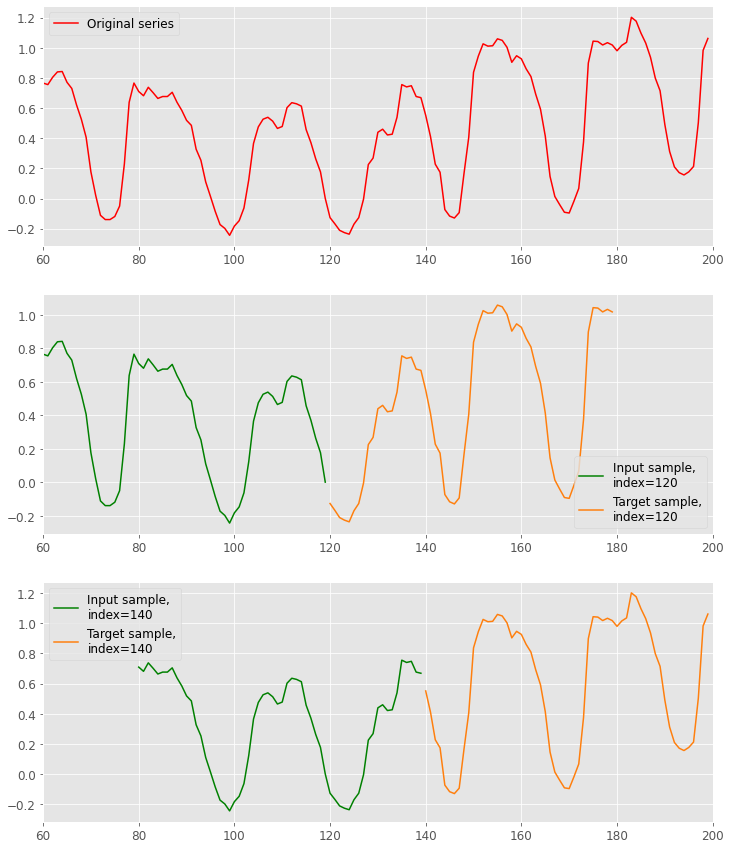

In [111]:
# Sanity check: Have we split the data correctly? 

lower = 60
upper = lower + 120

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
ax = ax.flatten()

ax[0].plot(x_train_w_feats.iloc[lower:upper + 20].NO5, c='r', label='Original series')
ax[0].set_xlim([lower, upper + 20])
ax[0].legend(fontsize=12)
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[1].plot(range(lower, lower + 60), x_train_seq[lower + 60][:, 0], c='g', label='Input sample,\nindex=' + str(lower + 60))
ax[1].plot(range(lower + 60, upper), scaler.transform(y_train_seq[lower + 60][:].reshape(-1, 1)), c='tab:orange',
          label='Target sample,\nindex=' + str(lower + 60))
ax[1].set_xlim([lower, upper + 20])
ax[1].legend(fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

ax[2].plot(range(lower + 20, lower + 80), x_train_seq[lower + 80][:, 0], c='g',
           label='Input sample,\nindex=' + str(lower + 80))
ax[2].plot(range(lower + 80, upper + 20), scaler.transform(y_train_seq[lower + 80][:].reshape(-1, 1)), c='tab:orange',
           label='Target sample,\nindex=' + str(lower + 80))
ax[2].set_xlim([lower, upper + 20])
ax[2].legend(fontsize=12)
ax[2].tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [112]:
fig.savefig('../../plots/NordPool/modelling/rnn_training_split.png', bbox_inches='tight')

The consumption part of the input as well as the target looks OK.

In [113]:
# Remove first and last 60 values, as these will include NaNs
x_train_seq = x_train_seq[60:-60]
y_train_seq = y_train_seq[60:-60]

Here we will be using a simple sequence-to-vector RNN architecture. Note that with this architecture, the model will not get any input data about the target hours it is trying to forecast for. For example, it will not know whether a given hour it is forecasting consumption/load for occurs during a holiday. This could be solved using for example an encoder-decoder RNN architecture. 

In [114]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(20, activation='relu', return_sequences=True, input_shape=(None, 9)))
rnn_model.add(SimpleRNN(20, activation='relu'))

# Add mean of training targets as the bias initializer for the last layer
last_layer_bias_init = constant_init(value=y_train[:-8760].mean())

rnn_model.add(Dense(60, bias_initializer=last_layer_bias_init))

In [115]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          600       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                1260      
Total params: 2,680
Trainable params: 2,680
Non-trainable params: 0
_________________________________________________________________


In [116]:
batch_size = 32
opti = Adam(learning_rate=0.001)

rnn_model.compile(optimizer=opti, 
                 loss=tf.keras.losses.MeanSquaredError(), 
                 metrics=[tf.keras.metrics.RootMeanSquaredError(),
                          tf.keras.metrics.MeanAbsoluteError(),
                          tf.keras.metrics.MeanAbsolutePercentageError()])

In [117]:
%%time

early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    restore_best_weights=True,
)


# Using the last year of data as validation (note that there will be a small overlap in training and validation data here)
history= rnn_model.fit(x=x_train_seq[:-8760], 
                      y=y_train_seq[:-8760], 
                      batch_size=batch_size,
                      validation_data=(x_train_seq[-8760:],
                                       y_train_seq[-8760:]),
                      epochs=150,
                      callbacks=[early_stopping],
                      verbose=0,
                      shuffle=True)

CPU times: user 2h 18min 31s, sys: 19min 30s, total: 2h 38min 2s
Wall time: 1h 8min 5s


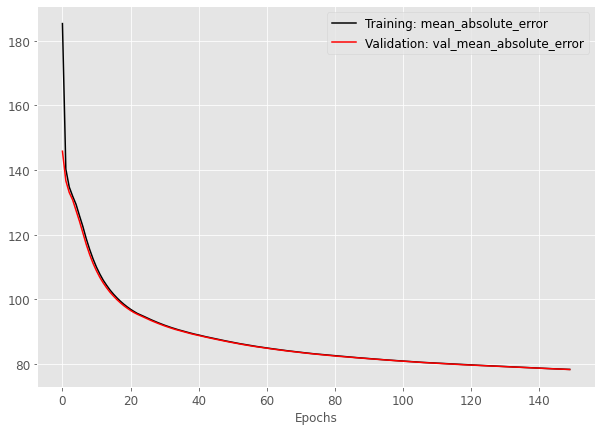

In [118]:
fig = visualize_training_nn(history, 
                            train_metric='mean_absolute_error',
                            val_metric='val_mean_absolute_error')

In [119]:
fig.savefig('../../plots/NordPool/modelling/rnn_training_history.png', bbox_inches='tight')

In [120]:
y_pred_rnn = rnn_model.predict(x_test_seq)

In [121]:
# Only keep every 60th prediction and flatten it to get a continous series
y_pred_rnn = pd.Series(y_pred_rnn[::60].flatten())

In [122]:
add_results('recurrent_neural_net', df_results, y_test, y_pred_rnn)

In [123]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,rmse,mae,mape
0,naive_7d_ago,0.772,173.29,134.1,7.82%
1,naive_24h_mean,0.793,164.89,132.4,7.56%
2,linear_regression,0.86,135.99,102.5,6.09%
3,random_forest,0.886,122.38,90.1,5.44%
4,xgboost,0.905,112.01,82.7,4.93%
5,xgboost,0.878,126.88,96.7,5.77%
6,xgboost,0.908,110.11,83.0,4.98%
7,recurrent_neural_net,0.917,104.7,77.6,4.46%


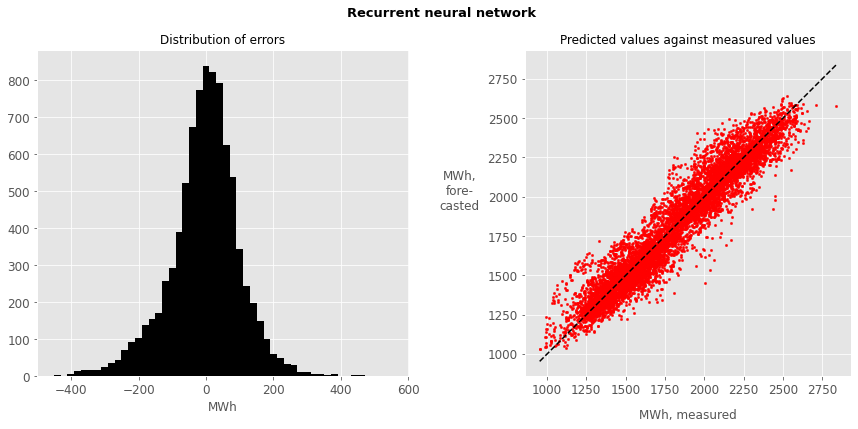

In [124]:
fig = plot_test_results(y_test, y_pred_rnn, 'Recurrent neural network')

In [125]:
fig.savefig('../../plots/NordPool/modelling/errors_rnn.png', bbox_inches='tight')

The RNN is less biased than the gradient boosting model, and also scores better on all metrics looked at.

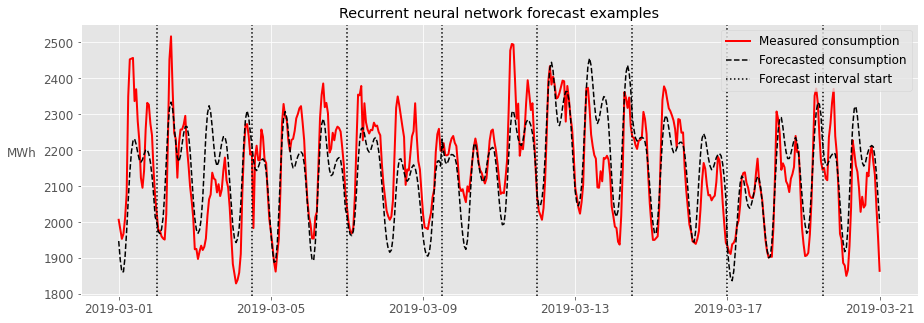

In [126]:
fig = plot_predictions(y_test, y_pred_rnn, 'Recurrent neural network', df_test, 
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [127]:
fig.savefig('../../plots/NordPool/modelling/rnn_forecast_examples_1.png', bbox_inches='tight')

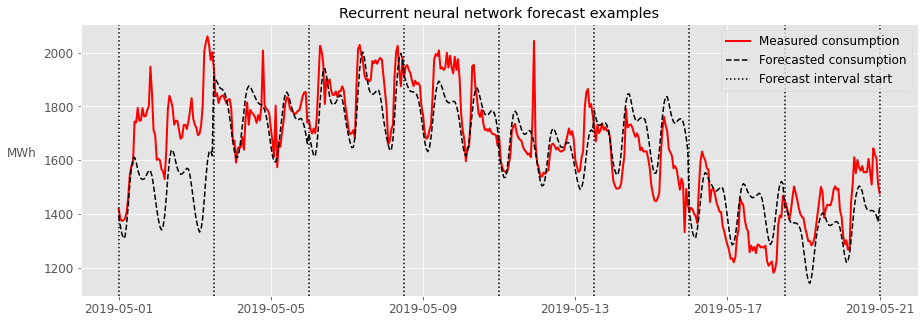

In [128]:
fig = plot_predictions(y_test, y_pred_rnn, 'Recurrent neural network', df_test,
                       start=pd.Timestamp('2019-05-01'), end=pd.Timestamp('2019-05-21'))

In [129]:
fig.savefig('../../plots/NordPool/modelling/rnn_forecast_examples_2.png', bbox_inches='tight')

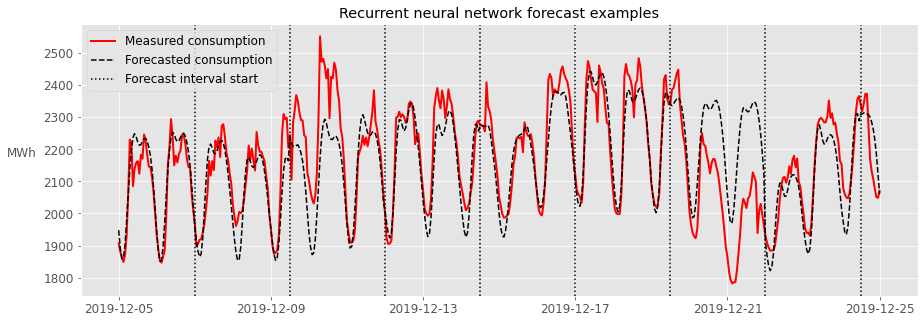

In [130]:
fig = plot_predictions(y_test, y_pred_rnn, 'Recurrent neural network', df_test,
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [131]:
fig.savefig('../../plots/NordPool/modelling/rnn_forecast_examples_3.png', bbox_inches='tight')